<a href="https://colab.research.google.com/github/RNEequalRNA/youtube-data-acquisition/blob/main/sample2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import helper
from helper import *

[nltk_data] Downloading package punkt to /home/hamerin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hamerin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hamerin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hamerin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def reload():
    exec('''__import__('importlib').reload(helper)
from helper import *
    ''')

In [3]:
reload()

[nltk_data] Downloading package punkt to /home/hamerin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hamerin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hamerin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hamerin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
# 긍정적, 부정적 단어 데이터셋 불러오기
positiveWords = pd.Series([*map(stemmer.stem, pd.read_csv('positive.txt')['words'])]).unique()
negativeWords = pd.Series([*map(stemmer.stem, pd.read_csv('negative.txt')['words'])]).unique()

In [46]:
videoIdList = retrieve_playlist_videos('PLS3XGZxi7cBVTzEE4Sim9UuNKnUJq9Vkh', 6)  # 플레이리스트에서 처음 50개 영상의 ID 수집
len(videoIdList)

300

In [50]:
videoIdList = videoIdList[::6]

In [84]:
dt = resp.json()


kind
etag
nextPageToken
items
pageInfo


In [3]:
videoIdList = [*map(lambda x: x['id']['videoId'], get_recent_videos('UCupvZG-5ko_eiXAupbDfxWw')['items'])]

In [4]:
videoIdList[-1]

'PZr5UQ4W9Vc'

In [51]:
# API를 통해 비디오의 모든 댓글, 통계 정보(좋아요, 조회수 등)을 수집한다. API 호출 오류를 대비하여 최대 10번까지 재시도한다.
statisticsList = []
commentsList = []
commentsTimestamp = []

from pqdm.processes import pqdm

def try_retrieve_comments(id):
    global statisticsList, commentsList, commentsTimestamp

    statisticsList.append(retrieve_statistics(id))
    
    retries = 0
    while True:
        flag = True
        if retries >= 10:
            # print("MAX RETRIES REACHED")
            commentsList.append([])
            commentsTimestamp.append([])
            break
        try:
            comment, timestamp = retrieve_comments(id)
            print(len(comment))

            commentsList.append(comment)
            commentsTimestamp.append(timestamp)
        except AssertionError:
            flag = False
            retries += 1
        finally:
            if flag:
                break

for id in tqdm(videoIdList):
    try_retrieve_comments(id)

100%|██████████| 50/50 [07:39<00:00,  9.19s/it]460



In [52]:
len(commentsList)

50

In [10]:
# 데이터 파일로부터 데이터 불러오기
DIRECTORY_NAME = 'data_bbc_0811'
with open(f'{DIRECTORY_NAME}/videoid.txt', 'r') as f:
    exec(f"videoIdList = {f.read()}")
with open(f'{DIRECTORY_NAME}/statistics.txt', 'r') as f:
    exec(f"statisticsList = {f.read()}")
with open(f'{DIRECTORY_NAME}/comments.txt', 'r') as f:
    exec(f"commentsList = {f.read()}")
with open(f'{DIRECTORY_NAME}/timestamp.txt', 'r') as f:
    exec(f"commentsTimestamp = {f.read()}")

In [11]:
len(commentsList), sum(map(lambda x: len(x), commentsList))

(50, 15523)

In [12]:
allComments = []
for comments in commentsList: allComments += comments

# (단어, 빈도)를 담고 있는 전체 영상에 대한 빈도수 데이터프레임 생성
freqDataFrame = get_freq(allComments)
freqDataFrame

,word,freq
343,peopl,1515
19,world,904
86,bbc,890
95,countri,866
168,god,669
...,...,...
3087,jesuchrist,1
6816,faster,1
6815,ammo,1
3088,bibli,1


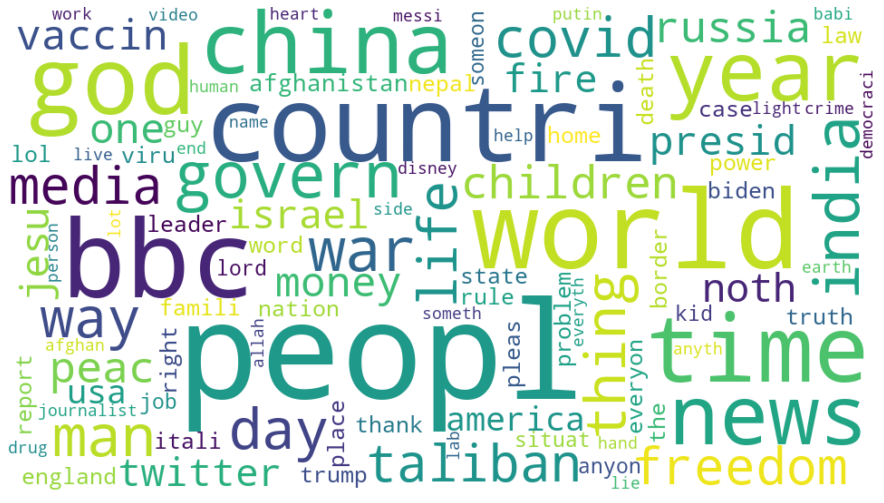

In [55]:
# 빈도수 데이터프레임을 기반으로 Word Cloud 생성
draw_wordcloud(freqDataFrame)

In [13]:
words = []
times = []
for i in tqdm(range(len(videoIdList))):
    for j in range(len(commentsList[i])):
        time = parse(commentsTimestamp[i][j]).timestamp()
        
        for word in get_words(commentsList[i][j]):
            words.append(word)
            times.append(time)


# (단어, 단어의 출현 시간(댓글이 작성된 시간))을 담고 있는 데이터프레임 생성
wordtimeDataFrame = pd.DataFrame(columns=['word', 'time'], data={
    'word': words,
    'time': times
})

100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


In [5]:
PARTITION_SIZE = 60
bins = np.linspace(min(wordtimeDataFrame['time']), max(wordtimeDataFrame['time']), PARTITION_SIZE + 1)  # 수집된 시간의 최소와 최대를 PARTITION_SIZE개의 구간으로 나누기

In [14]:
positiveWordsMask = wordtimeDataFrame['word'].isin(positiveWords)
negativeWordsMask = wordtimeDataFrame['word'].isin(negativeWords)

values = []
for index in range(PARTITION_SIZE):
    start = bins[index]
    end = bins[index + 1]

    rangeMask = (start <= wordtimeDataFrame['time']) & (wordtimeDataFrame['time'] < end)
    
    positiveCount = len(wordtimeDataFrame[positiveWordsMask & rangeMask])
    negativeCount = len(wordtimeDataFrame[negativeWordsMask & rangeMask])

    values.append(positiveCount / max(1, positiveCount + negativeCount))

In [15]:
values2 = values

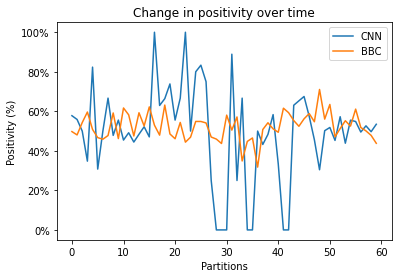

(array([1.62031455e+09, 1.62045362e+09, 1.62059270e+09, 1.62073177e+09,
        1.62087085e+09, 1.62100992e+09, 1.62114900e+09, 1.62128807e+09,
        1.62142715e+09, 1.62156622e+09, 1.62170530e+09, 1.62184437e+09,
        1.62198345e+09, 1.62212252e+09, 1.62226160e+09, 1.62240067e+09,
        1.62253975e+09, 1.62267882e+09, 1.62281790e+09, 1.62295697e+09,
        1.62309605e+09, 1.62323513e+09, 1.62337420e+09, 1.62351328e+09,
        1.62365235e+09, 1.62379143e+09, 1.62393050e+09, 1.62406958e+09,
        1.62420865e+09, 1.62434773e+09, 1.62448680e+09, 1.62462588e+09,
        1.62476495e+09, 1.62490403e+09, 1.62504310e+09, 1.62518218e+09,
        1.62532125e+09, 1.62546033e+09, 1.62559940e+09, 1.62573848e+09,
        1.62587755e+09, 1.62601663e+09, 1.62615570e+09, 1.62629478e+09,
        1.62643385e+09, 1.62657293e+09, 1.62671200e+09, 1.62685108e+09,
        1.62699015e+09, 1.62712923e+09, 1.62726830e+09, 1.62740738e+09,
        1.62754645e+09, 1.62768553e+09, 1.62782460e+09, 1.627963

In [20]:
fig, ax = plt.subplots()
ax.plot(values1, label='CNN')
ax.plot(values2, label='BBC')
ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.title('Change in positivity over time')
plt.ylabel('Positivity (%)')
plt.xlabel('Partitions')

plt.legend()

bins, plt.show()

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

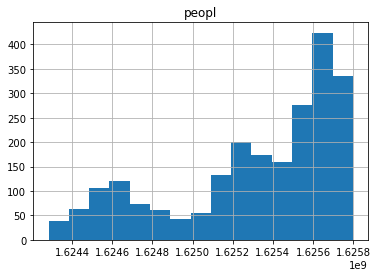

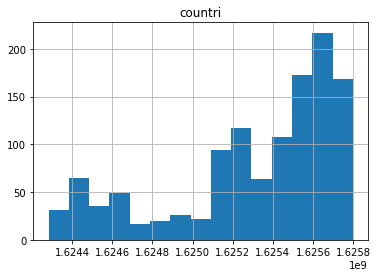

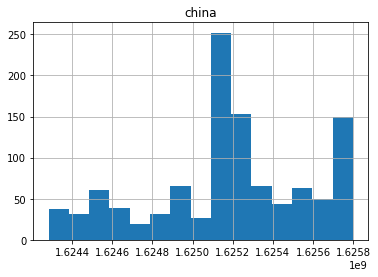

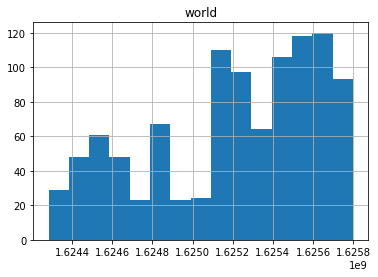

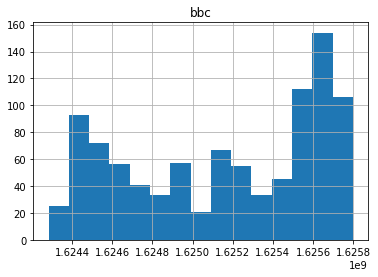

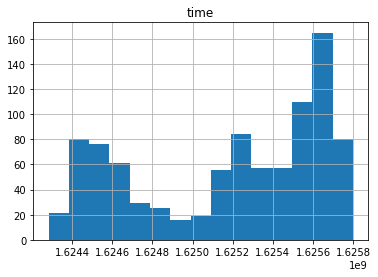

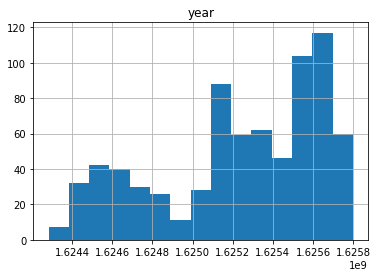

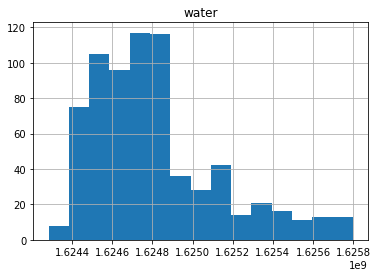

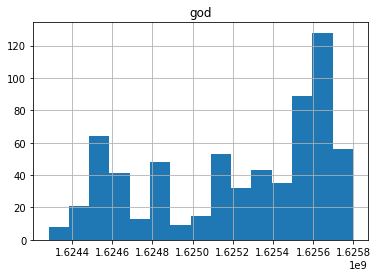

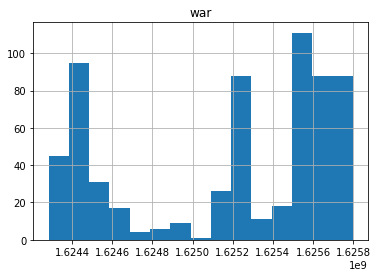

In [12]:
for word in freqDataFrame['word'].head(10):  # head 메소드로 가장 빈도수 높은 10개만
    display(wordtimeDataFrame[wordtimeDataFrame['word'] == word].hist(bins=bins))  # 아까 나눈 구간별로 빈도수 히스토그램 그리기
    plt.title(word)

In [61]:
# timevectorDict[word]는 아까 나눈 word의 구간별 빈도수를 PARTITION_SIZE차원의 벡터로 만들고, 이를 정규화(크기를 1로 만듦)시킨 것
timeVectorDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    timeVectorDict[word] = get_freq_vec(wordtimeDataFrame, word, bins)

100%|██████████| 100/100 [00:03<00:00, 25.60it/s]


In [62]:
# 코사인 유사도 기반 유사도 데이터프레임 만들기
word1 = []
word2 = []
similarity = []
for w1, v1 in timeVectorDict.items():
    for w2, v2 in timeVectorDict.items():
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(v1, v2))  # 아까 만든 벡터의 코사인 유사도를 구함

timeSimilarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬
timeSimilarityDataFrame[:30]

,word1,word2,similarity
613,afghanistan,taliban,0.993704
3776,afghan,afghanistan,0.977809
3759,afghan,taliban,0.973531
1522,itali,england,0.947252
21,year,peopl,0.889252
10,time,peopl,0.885783
4705,putin,biden,0.879692
26,year,time,0.876306
485,twitter,freedom,0.874235
1,bbc,peopl,0.872790


In [64]:
# tfidfVectorDict[word]는 word의 tf-idf 결과를 (문서 개수)차원의 벡터로 나타낸 것
freqList = [get_freq(comments) for comments in tqdm(commentsList)]  # freqList[i]는 i번째 영상의 빈도수 데이터프레임
tfidfVectorDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    tfidfVectorDict[word] = tf_idf(word, freqList)

100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


In [65]:
# 코사인 유사도 기반 유사도 데이터프레임 만들기
word1 = []
word2 = []
similarity = []
for w1, v1 in tfidfVectorDict.items():
    for w2, v2 in tfidfVectorDict.items():
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))  # 아까 만든 벡터의 코사인 유사도를 구함

tfidfSimilarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬
tfidfSimilarityDataFrame[:30]

,word1,word2,similarity
613,afghanistan,taliban,0.993103
3759,afghan,taliban,0.985199
3776,afghan,afghanistan,0.975303
1522,itali,england,0.974217
4618,lab,viru,0.902561
485,twitter,freedom,0.886525
3404,end,world,0.882563
1363,home,england,0.880791
4123,side,israel,0.879716
594,usa,america,0.874009


In [66]:
tokenizedContents = []
for document in tqdm(commentsList):
    for sentence in document:
        tokenizedContents.append(get_words(sentence))

model = Word2Vec(tokenizedContents, size=100, window=2, min_count=50, workers=16, iter=100, sg=1)

100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


In [67]:
# word2vecVectorDict[word]는 word의 word2vec 학습 결과를 (문서 개수)차원의 벡터로 나타낸 것
word2vecVectorDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    word2vecVectorDict[word] = model.wv[word]

100%|██████████| 100/100 [00:00<00:00, 379918.84it/s]


In [57]:
model.wv.save_word2vec_format('nyt_w2v')
!python -m gensim.scripts.word2vec2tensor --input nyt_w2v --output nyt_w2v


2021-07-12 02:33:30,994 - word2vec2tensor - INFO - running /home/hamerin/anaconda3/lib/python3.8/site-packages/gensim/scripts/word2vec2tensor.py --input nyt_w2v --output nyt_w2v
2021-07-12 02:33:30,994 - utils_any2vec - INFO - loading projection weights from nyt_w2v
2021-07-12 02:33:31,060 - utils_any2vec - INFO - loaded (871, 100) matrix from nyt_w2v
2021-07-12 02:33:31,127 - word2vec2tensor - INFO - 2D tensor file saved to nyt_w2v_tensor.tsv
2021-07-12 02:33:31,127 - word2vec2tensor - INFO - Tensor metadata file saved to nyt_w2v_metadata.tsv
2021-07-12 02:33:31,128 - word2vec2tensor - INFO - finished running word2vec2tensor.py


In [68]:
# 코사인 유사도 기반 유사도 데이터프레임 만들기
word1 = []
word2 = []
similarity = []
for w1, v1 in word2vecVectorDict.items():
    for w2, v2 in word2vecVectorDict.items():
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))  # 아까 만든 벡터의 코사인 유사도를 구함

word2vecSimilarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬
word2vecSimilarityDataFrame[:30]

,word1,word2,similarity
613,afghanistan,taliban,0.532923
30,news,bbc,0.521592
439,jesu,god,0.505044
3776,afghan,afghanistan,0.501788
2376,lord,jesu,0.500841
1522,itali,england,0.500290
3759,afghan,taliban,0.499382
83,thing,time,0.498125
316,vaccin,covid,0.484033
992,report,bbc,0.482944


In [69]:
# TSNE(t-Stochastic Neighbor Embedding) 방법을 이용한 시각화
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

timeVectorArray = np.array([*timeVectorDict.values()])
tfidfVectorArray = np.array([*tfidfVectorDict.values()])
word2vecVectorArray = np.array([*word2vecVectorDict.values()])

timeVectorArrayEmbedded = tsne.fit_transform(timeVectorArray)
tfidfVectorArrayEmbedded = tsne.fit_transform(tfidfVectorArray)
word2vecVectorArrayEmbedded = tsne.fit_transform(word2vecVectorArray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.361119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.372261
[t-SNE] KL divergence after 1500 iterations: 0.462656
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 93.850181
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.911900
[t-SNE] KL divergence after 1100 iterations: 0.349392
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.654491
[t-SNE] KL divergence after 250 iterati

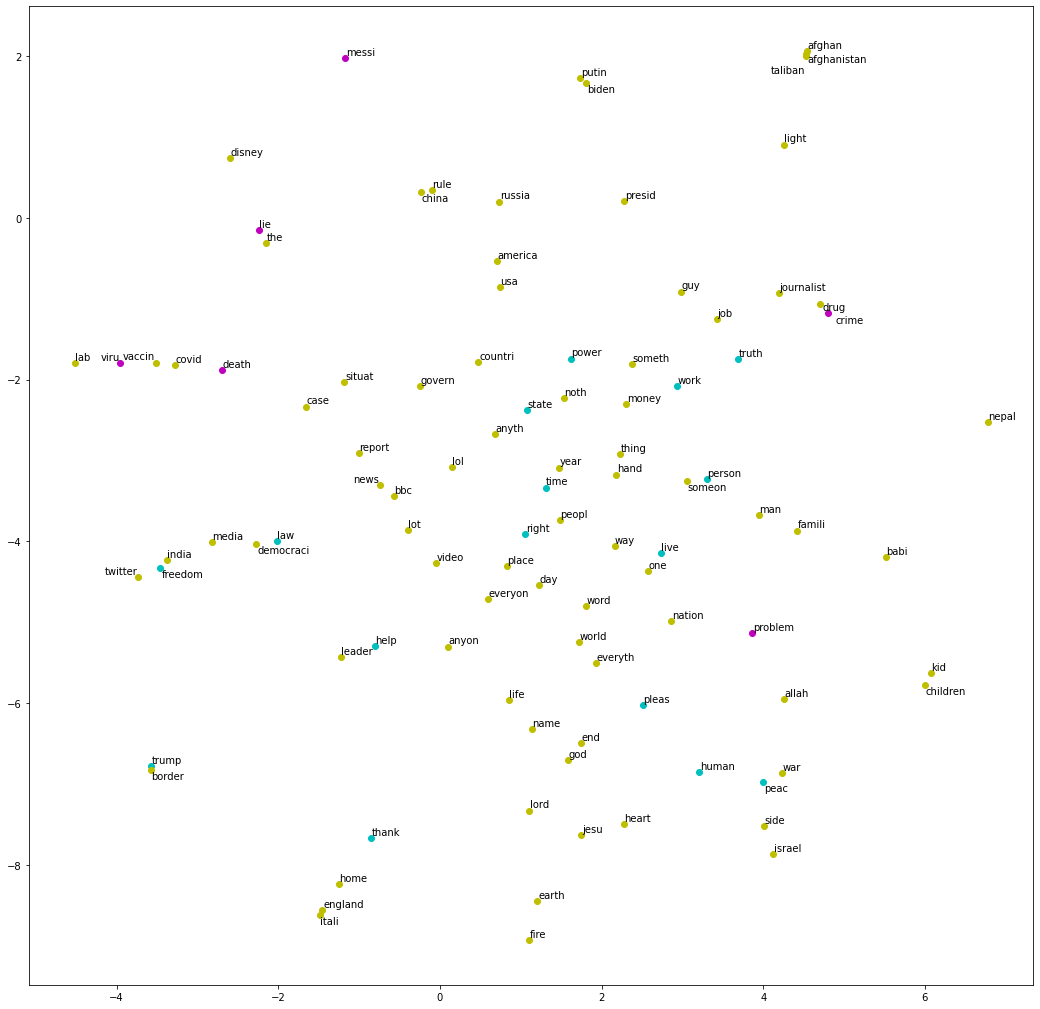

In [70]:
plt.figure(figsize=(18, 18))

texts = []
toScatter = {'c': [[], []], 'y': [[], []], 'm':[[], []]}
for index, key in enumerate(timeVectorDict):
    x = timeVectorArrayEmbedded[index, 0]
    y = timeVectorArrayEmbedded[index, 1]

    if key in positiveWords:
        toScatter['c'][0].append(x)
        toScatter['c'][1].append(y)
    elif key in negativeWords:
        toScatter['m'][0].append(x)
        toScatter['m'][1].append(y)
    else:
        toScatter['y'][0].append(x)
        toScatter['y'][1].append(y)

    texts.append(plt.text(x, y, key))

for color, coordinates in toScatter.items():
    plt.scatter(coordinates[0], coordinates[1], color=color)

helper.adjust_text(texts)

plt.show()

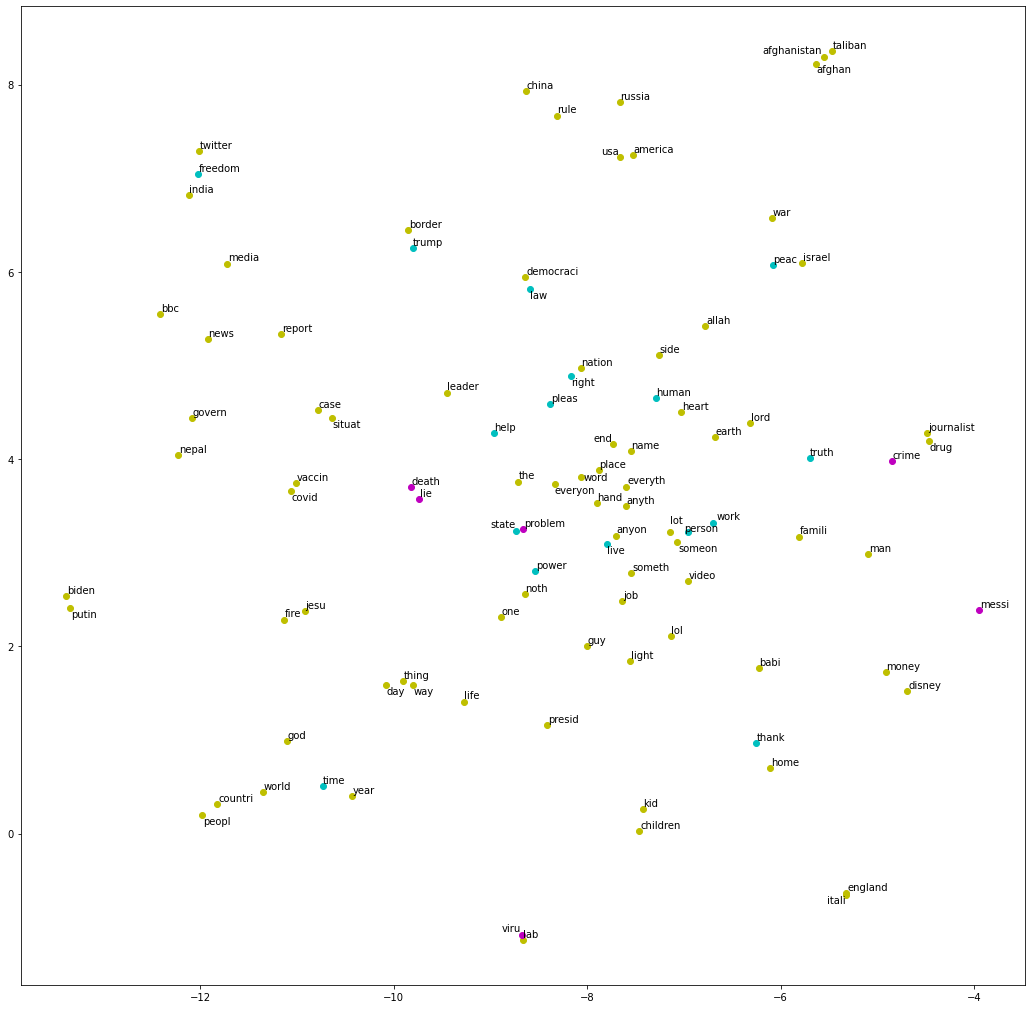

In [71]:
plt.figure(figsize=(18, 18))

texts = []
toScatter = {'c': [[], []], 'y': [[], []], 'm':[[], []]}
for index, key in enumerate(tfidfVectorDict):
    x = tfidfVectorArrayEmbedded[index, 0]
    y = tfidfVectorArrayEmbedded[index, 1]

    if key in positiveWords:
        toScatter['c'][0].append(x)
        toScatter['c'][1].append(y)
    elif key in negativeWords:
        toScatter['m'][0].append(x)
        toScatter['m'][1].append(y)
    else:
        toScatter['y'][0].append(x)
        toScatter['y'][1].append(y)

    texts.append(plt.text(x, y, key))

for color, coordinates in toScatter.items():
    plt.scatter(coordinates[0], coordinates[1], color=color)

helper.adjust_text(texts)

plt.show()

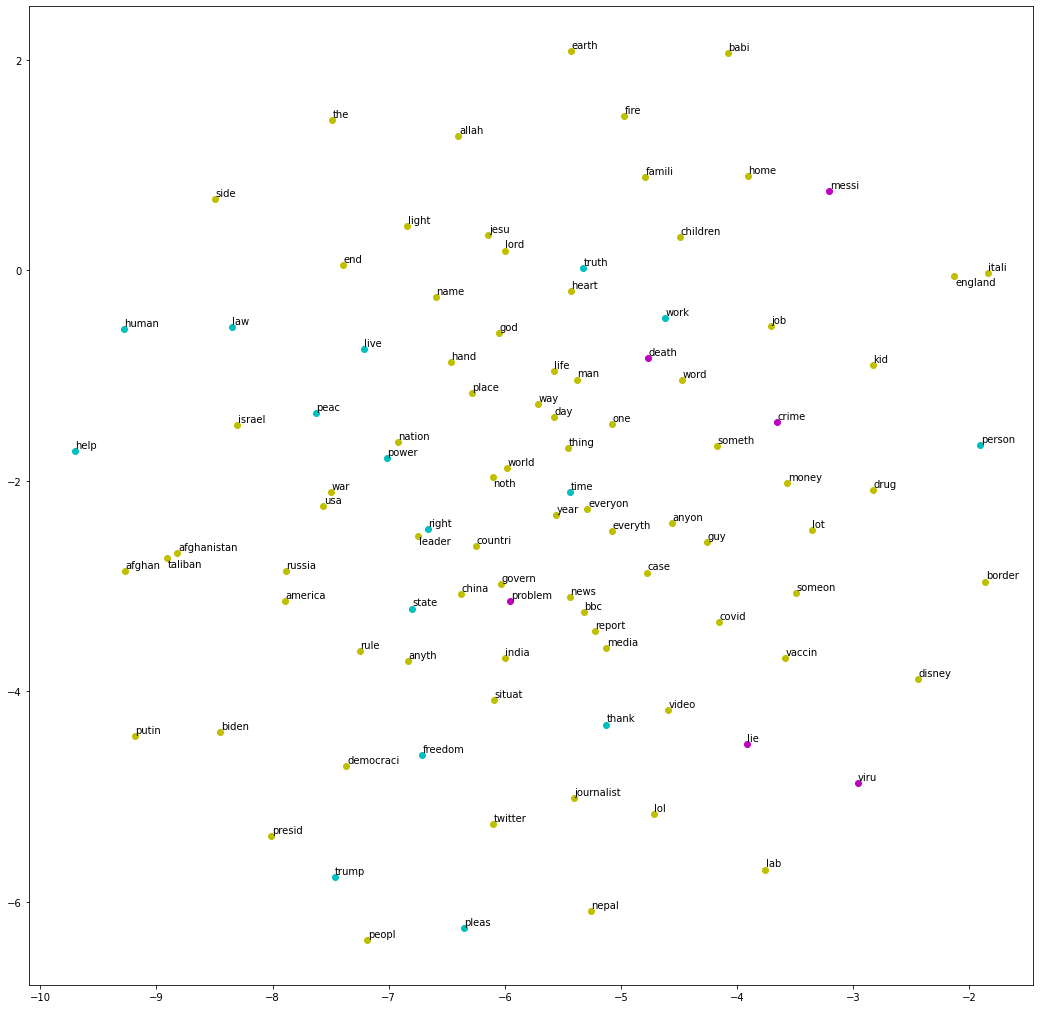

In [72]:
plt.figure(figsize=(18, 18))

texts = []
toScatter = {'c': [[], []], 'y': [[], []], 'm':[[], []]}
for index, key in enumerate(word2vecVectorDict):
    x = word2vecVectorArrayEmbedded[index, 0]
    y = word2vecVectorArrayEmbedded[index, 1]

    if key in positiveWords:
        toScatter['c'][0].append(x)
        toScatter['c'][1].append(y)
    elif key in negativeWords:
        toScatter['m'][0].append(x)
        toScatter['m'][1].append(y)
    else:
        toScatter['y'][0].append(x)
        toScatter['y'][1].append(y)

    texts.append(plt.text(x, y, key))

for color, coordinates in toScatter.items():
    plt.scatter(coordinates[0], coordinates[1], color=color)

helper.adjust_text(texts)

plt.show()

In [56]:
# 데이터 저장
DIRECTORY_NAME = 'data_bbc_0811'
with open(f'{DIRECTORY_NAME}/videoid.txt', 'w') as f:
    f.write(str(videoIdList))
with open(f'{DIRECTORY_NAME}/statistics.txt', 'w') as f:
    f.write(str(statisticsList))
with open(f'{DIRECTORY_NAME}/comments.txt', 'w') as f:
    f.write(str(commentsList))
with open(f'{DIRECTORY_NAME}/timestamp.txt', 'w') as f:
    f.write(str(commentsTimestamp))